# Прогноз оттока клиентов

**Задача исследования** - посторить модель машинного обучения, предсказывающую отток клиентов телеком-компании.

В нашем распоряжении персональные данные о некоторых клиентах, информация об их тарифах и договорах. Целевая метрика - AUC-ROC.

## Содержание

1. [Предобработка данных](#start)
2. [Исследовательский анализ данных](#EDA)
    * 2.1 [Выводы исследовательского анализа данных](#EDA_result)
3. [Обучение моделей](#model)
    * 3.1 [Логистическая регрессия](#regression)
    * 3.2 [Градиентный бустинг LGBM](#lgbm)
    * 3.3 [Случайный лес](#forest)
4. [Проверка моделей](#test)
5. [Выводы](#conclusion)

## Предобработка данных <a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
contract = pd.read_csv('C:/Downloads/dataset/final_provider/contract.csv')
internet = pd.read_csv('C:/Downloads/dataset/final_provider/internet.csv')
personal = pd.read_csv('C:/Downloads/dataset/final_provider/personal.csv')
phone = pd.read_csv('C:/Downloads/dataset/final_provider/phone.csv')

In [4]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В нашем распоряжении информация о 7043 клиентах компании Ниединогоразрыва.ком. Часть этих клиентов является пользователями интернета от компании-провайдера, часть - пользователями услуг телефонии, некоторые клиенты пользуются и тем, и другим сервисом компании.

В ходе предобработки данных нам предстоит:

1. Переименовать столбцы, изменить тип данных, обработать пропуски
2. Объединить четыре датасета в один

Начнём с таблицы contract, в которой хранится информация о контрактах:

In [9]:
contract.set_axis([
    'customer_id',
    'begin_date',
    'end_date',
    'type',
    'paperless_billing',
    'payment_method',
    'monthly_charges',
    'total_charges'
], axis = 'columns', inplace = True)

In [10]:
contract['total_charges'] = contract['total_charges'].replace(' ', np.nan)

In [11]:
contract['total_charges'] = contract['total_charges'].astype('float64')

In [12]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [13]:
contract[contract.isna().any(axis=1)]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Мы заменили пропусками все строковые значения в столбце total_charges и преобразовали тип данных в нём на числовой. Далее мы построим гистограммы распределения и решим, как поступать с пропусками.

In [14]:
contract.describe()

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


Меняем тип данных в столбцах paperless_billing и begin_date:

In [15]:
contract['paperless_billing'] = contract['paperless_billing'].replace('Yes', 1)
contract['paperless_billing'] = contract['paperless_billing'].replace('No', 0)
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

Посмотрим на значения в столбце end_date:

In [16]:
sorted(contract['end_date'].unique())

['2019-10-01 00:00:00',
 '2019-11-01 00:00:00',
 '2019-12-01 00:00:00',
 '2020-01-01 00:00:00',
 'No']

В столбце end_date всего четыре уникальные даты (помимо значения No). Судя по всему, отток клиентов начался в ноябре 2019 года. Сохранение данного столбца не даст нам много информации - используем его, чтобы создать столбец churn (целевой признак) и добавим признак "длительность контракта":

In [17]:
def make_churn(value):
    if value == 'No':
        return 0
    else:
        return 1

In [18]:
contract['churn'] = contract['end_date'].apply(make_churn)

In [19]:
contract['end_date'] = contract['end_date'].replace('No', '2020-02-01')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
contract['contract_duration'] = contract['end_date'] - contract['begin_date']
contract['contract_duration'] = contract['contract_duration'].dt.days
del contract['end_date']

In [20]:
contract

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration
0,7590-VHVEG,2020-01-01,Month-to-month,1,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,One year,0,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,Month-to-month,1,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,Month-to-month,1,Electronic check,70.70,151.65,1,61
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,One year,1,Mailed check,84.80,1990.50,0,730
7039,2234-XADUH,2014-02-01,One year,1,Credit card (automatic),103.20,7362.90,0,2191
7040,4801-JZAZL,2019-03-01,Month-to-month,1,Electronic check,29.60,346.45,0,337
7041,8361-LTMKD,2019-07-01,Month-to-month,1,Mailed check,74.40,306.60,1,123


Посмотрим на значения в столбцах type и payment_method:

In [21]:
contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [22]:
contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [23]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


В таблице internet предстоит переименовать столбцы и поменять тип данных. Также добавим в неё столбец internet_user, который будет содержать информацию о том, что человек является пользователем данной услуги.

In [24]:
internet['internet_user'] = np.ones(internet.shape[0]).astype('int64')

In [25]:
internet.set_axis([
    'customer_id',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'internet_user'
], axis = 'columns', inplace = True)

internet[['online_security', 'online_backup', 'device_protection',
          'tech_support', 'streaming_tv', 'streaming_movies']] = internet[
    ['online_security', 'online_backup', 'device_protection',
          'tech_support', 'streaming_tv', 'streaming_movies']].replace('Yes', 1)
internet[['online_security', 'online_backup', 'device_protection',
          'tech_support', 'streaming_tv', 'streaming_movies']] = internet[
    ['online_security', 'online_backup', 'device_protection',
          'tech_support', 'streaming_tv', 'streaming_movies']].replace('No', 0)
internet

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet_user
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,1,0,1,1,1,1,1
5513,2234-XADUH,Fiber optic,0,1,1,0,1,1,1
5514,4801-JZAZL,DSL,1,0,0,0,0,0,1
5515,8361-LTMKD,Fiber optic,0,0,0,0,0,0,1


In [26]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [27]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [28]:
personal.set_axis([
    'customer_id',
    'gender',
    'senior_citizen',
    'partner',
    'dependents'
], axis = 'columns', inplace = True)

personal[['partner', 'dependents']] = personal[['partner', 'dependents']].replace('Yes', 1)
personal[['partner', 'dependents']] = personal[['partner', 'dependents']].replace('No', 0)
personal

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0
...,...,...,...,...,...
7038,6840-RESVB,Male,0,1,1
7039,2234-XADUH,Female,0,1,1
7040,4801-JZAZL,Female,0,1,1
7041,8361-LTMKD,Male,1,1,0


In [29]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Это таблица с информацией о пользователях услугами телефонии. Добавим в неё столбец phone_service, который будет содержать информацию о том, что человек является пользователем данной услуги.

In [30]:
phone['phone_user'] = np.ones(phone.shape[0]).astype('int64')

In [31]:
phone.set_axis([
    'customer_id',
    'multiple_lines',
    'phone_user'], axis = 'columns', inplace = True)

phone['multiple_lines'] = phone['multiple_lines'].replace('Yes', 1)
phone['multiple_lines'] = phone['multiple_lines'].replace('No', 0)
phone

,customer_id,multiple_lines,phone_user
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1
...,...,...,...
6356,2569-WGERO,0,1
6357,6840-RESVB,1,1
6358,2234-XADUH,1,1
6359,8361-LTMKD,1,1


In [32]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
 2   phone_user      6361 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 149.2+ KB


In [33]:
data = contract.merge(
    personal, on='customer_id', how='outer').merge(
    internet, on='customer_id', how='outer').merge(
    phone, on='customer_id', how='outer')

In [34]:
data

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration,gender,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet_user,multiple_lines,phone_user
0,7590-VHVEG,2020-01-01,Month-to-month,1,Electronic check,29.85,29.85,0,31,Female,...,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,One year,0,Mailed check,56.95,1889.50,0,1036,Male,...,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3668-QPYBK,2019-10-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,Male,...,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,7795-CFOCW,2016-05-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,Male,...,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN
4,9237-HQITU,2019-09-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,Female,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,One year,1,Mailed check,84.80,1990.50,0,730,Male,...,DSL,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7039,2234-XADUH,2014-02-01,One year,1,Credit card (automatic),103.20,7362.90,0,2191,Female,...,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
7040,4801-JZAZL,2019-03-01,Month-to-month,1,Electronic check,29.60,346.45,0,337,Female,...,DSL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
7041,8361-LTMKD,2019-07-01,Month-to-month,1,Mailed check,74.40,306.60,1,123,Male,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   churn              7043 non-null   int64         
 8   contract_duration  7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   int64         
 12  dependents         7043 non-null   int64         
 13  internet_service   5517 non-null   object        
 14  online_s

Получившиеся после слияния таблиц пропуски будем заполнять следующим образом:

1. В столбцах online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, internet_user заполняем нулями, так как эти клиенты не являются пользователями интернета от данного провайдера. В столбце internet_service заполняем значением no service.
2. В столбцах phone_user и multiple_lines заполняем нулями, так как эти клиенты не пользуются услугами телефонии от компании.

In [36]:
data['internet_service'] = data['internet_service'].fillna('no service')

data[['online_security', 'online_backup', 'device_protection', 'tech_support',
      'streaming_tv', 'streaming_movies', 'internet_user', 'phone_user', 'multiple_lines']] = data[
    ['online_security', 'online_backup', 'device_protection', 'tech_support',
      'streaming_tv', 'streaming_movies', 'internet_user', 'phone_user', 'multiple_lines']].fillna(0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   churn              7043 non-null   int64         
 8   contract_duration  7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   int64         
 12  dependents         7043 non-null   int64         
 13  internet_service   7043 non-null   object        
 14  online_s

Осталось незначительное количество пропусков в столбце total_charges - мы примем решение по нему после проведения исследовательского анализа данных. 

## Исследовательский анализ данных <a id="EDA"></a>

Построим график распределения дат заключения контрактов:

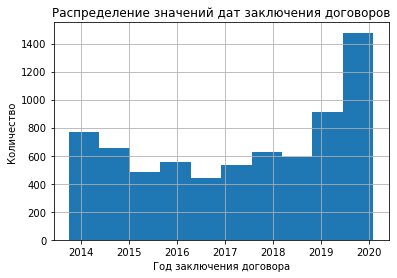

In [37]:
data['begin_date'].hist()
plt.xlabel('Год заключения договора')
plt.ylabel('Количество')
plt.title('Распределение значений дат заключения договоров');

Компания стабильно заключает договоры на протяжении последних 7 лет, при этом в 2020 году количество новых клиентов резко выросло более чем в два раза - тенденция положительная, но, как мы помним, отток клиентов так же начался в конце 2019.

In [38]:
data['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

Более 30% договоров было расторгнуто.

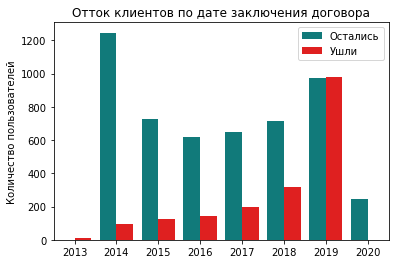

In [39]:
palette = {0:"darkcyan",
           1:"red"}
data['begin_year'] = data['begin_date'].dt.year
sns.countplot(x="begin_year", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по дате заключения договора');

Видим, что отток клиентов рос медленно и постепенно пропорционально росту количества новых клиентов, но в 2019 году произошёл резкий скачок - количество расторгнутых контрактов превысило количество новых.

In [40]:
data = data.drop(['begin_year'], axis=1)

Посмотрим, как распределяется количество ушедших клиентов в зависимости от различных факторов. Начнём с распределения по типу оплаты - ежемесячно или долгосрочно.

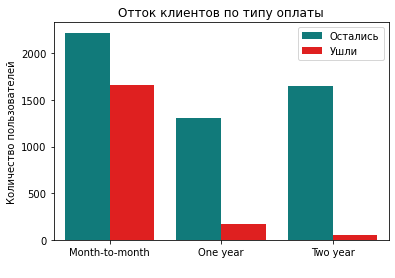

In [41]:
sns.countplot(x="type", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по типу оплаты');

Самый большой отток клиентов происходит в группе, совершающей оплату на ежемесячной основе.

Посмотрим, есть ли корреляция в зависимости от наличия иждивенцев или партнёра:

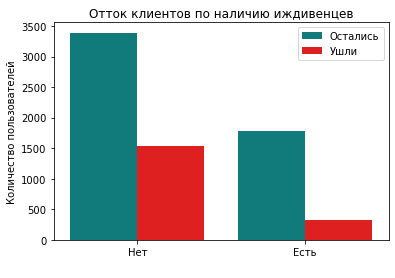

In [42]:
sns.countplot(x="dependents", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xticks(
    [0, 1], 
    ["Нет", "Есть"])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по наличию иждивенцев');

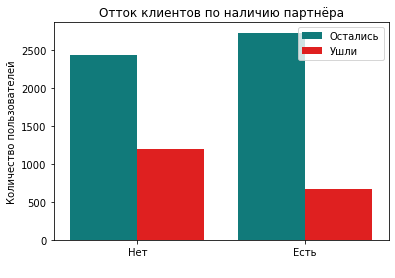

In [43]:
sns.countplot(x="partner", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xticks(
    [0, 1], 
    ["Нет", "Есть"])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по наличию партнёра');

Одинокоживущие абоненты чаще прекращают пользоваться услугами компании по сравнению с теми, у кого есть иждивенцы и партнёры, но в целом, опираясь на графики, нельзя сказать, что влияние этих факторов существенно, так как в процентном соотношении разница не слишком велика. 

Посмотрим на распределение оттока в зависимости от способа получения счёта за услуги:

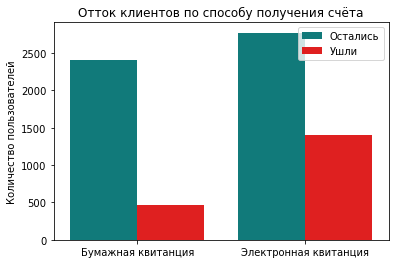

In [44]:
sns.countplot(x="paperless_billing", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xticks(
    [0, 1], 
    ["Бумажная квитанция", "Электронная квитанция"])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по способу получения счёта');

Среди тех, кто отказался от бумажных квитанций, процент ушедших выше.

Рассмотрим, как способ расчёта влияет на количество ушедших клиентов:

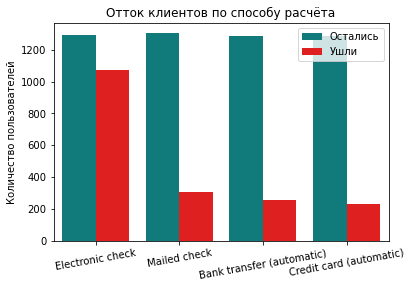

In [45]:
sns.countplot(x="payment_method", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xticks(rotation=10)
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по способу расчёта');

Клиенты, использующие автоматические способы оплаты являются более надёжными. Процент оттока среди клиентов, используюзих электронный расчёт, очень велик - компанию покидает почти половина таких клиентов.

Построим диаграмму оттока по способу подключения интернета:

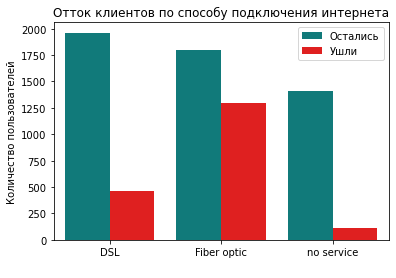

In [46]:
sns.countplot(x="internet_service", hue="churn", data=data, palette=palette)
plt.legend(title=False, loc='upper right', labels=['Остались', 'Ушли'])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов по способу подключения интернета');

Пользователи интернета, подключённого через оптоволокно, гораздо чаще прекращают пользоваться услугами компании в сравнениями с пользователями DSL-интернета.

Посмотрим на существование корреляции между значениями в таблице contract. Для этого построим график и матрицу корреляции:

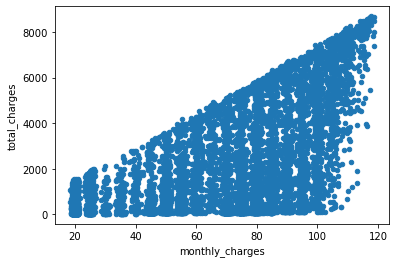

In [47]:
data.plot(x='monthly_charges', y='total_charges', kind='scatter');

In [48]:
contract.corr()

,paperless_billing,monthly_charges,total_charges,churn,contract_duration
paperless_billing,1.000000,0.352150,0.157830,0.191825,0.006059
monthly_charges,0.352150,1.000000,0.651065,0.193356,0.247754
total_charges,0.157830,0.651065,1.000000,-0.199484,0.825811
churn,0.191825,0.193356,-0.199484,1.000000,-0.352673
contract_duration,0.006059,0.247754,0.825811,-0.352673,1.000000


Имеем два признака, которые сильно коррелируют с признаком total_charges: это monthly_charges (коэффициент Пирсона 0,65) и contract_duration (коэффициент Пирсона 0,82). Видим на графике прямую зависимость между суммой ежемесячных трат клиента и общей суммой трат, с зависимостью между признаками "длительность контракта" и "суммарные траты" нет сомнений - чем дольше пользователь является клиентом компании, тем больше его суммарные траты. Перед обучением модели нужно будет удалить один из столбцов - total_charges (как раз в нём у нас были пропуски).

Взглянем на распределение значений ежемесячных трат:

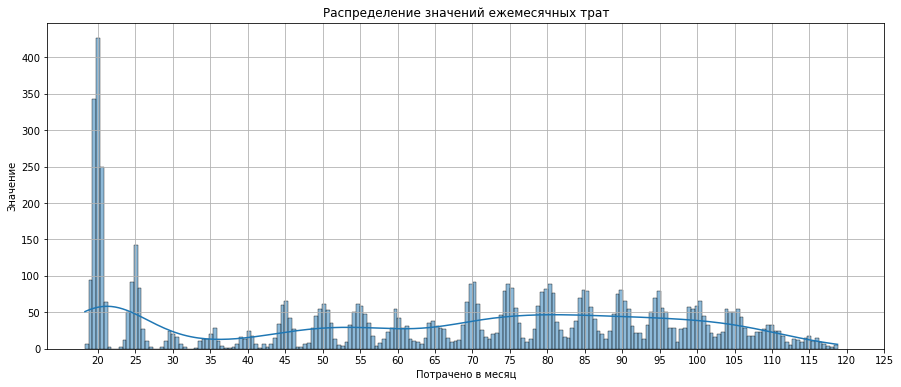

In [49]:
plt.figure(figsize=(15,6))
plt.grid()
sns.histplot(data=data, x="monthly_charges", bins=200, kde=True)
plt.xlabel('Потрачено в месяц')
plt.ylabel('Значение')
plt.xticks(np.arange(20, 130, 5))
plt.title('Распределение значений ежемесячных трат');

У графика много пиков - каждый из них приходится на "юбилейное" число (20, 25, 30 и т.д.). Возможно, это связано с системой предоплаты, а не постоплаты - скорее всего, пользователи вносят сумму кратную пяти.

Построим диаграмму размаха:

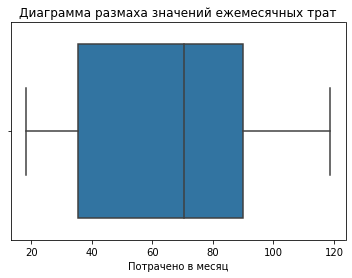

In [50]:
sns.boxplot(x=data['monthly_charges'])
plt.xlabel('Потрачено в месяц')
plt.title('Диаграмма размаха значений ежемесячных трат');

Несмотря на разброс значений ежемесячных трат, согласно диаграмме размаха в нашей выборке отсутствуют аномалии. Большинство пользователей тратит на услуги от 35 до 90 в месяц, в среднем 64.

Построим диаграммы для суммарных значений трат:

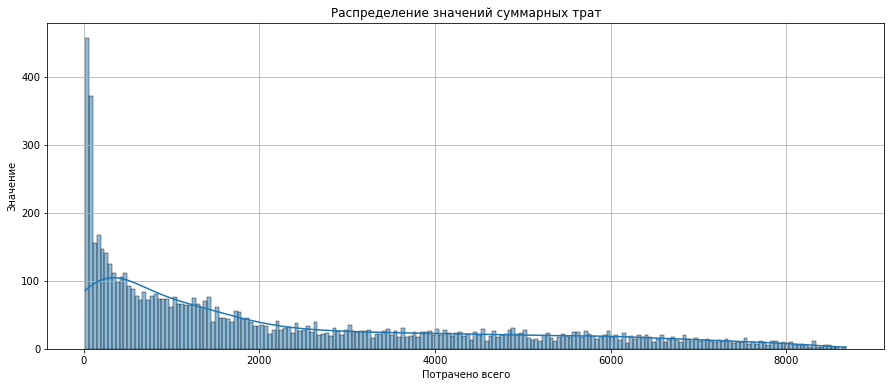

In [51]:
plt.figure(figsize=(15,6))
plt.grid()
sns.histplot(data=data, x="total_charges", bins=200, kde=True)
plt.xlabel('Потрачено всего')
plt.ylabel('Значение')
plt.title('Распределение значений суммарных трат');

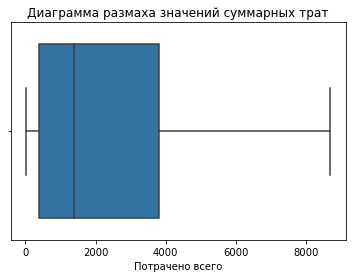

In [52]:
sns.boxplot(x=data['total_charges'])
plt.xlabel('Потрачено всего')
plt.title('Диаграмма размаха значений суммарных трат');

Выбросов также нет, данные распределены иначе чем значения в столбце monthly_charges - график сильно скошен вправо, что говорит о том, что в нашей выборке много крупных значений total_charges. Это может быть связано с тем, что значительная часть клиентов уже длительное время пользуется услугами компании.

In [53]:
data[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


Оценим соотношение ежемесячных трат среди действительных клиентов и тех, кто расторгнул договор с компанией:

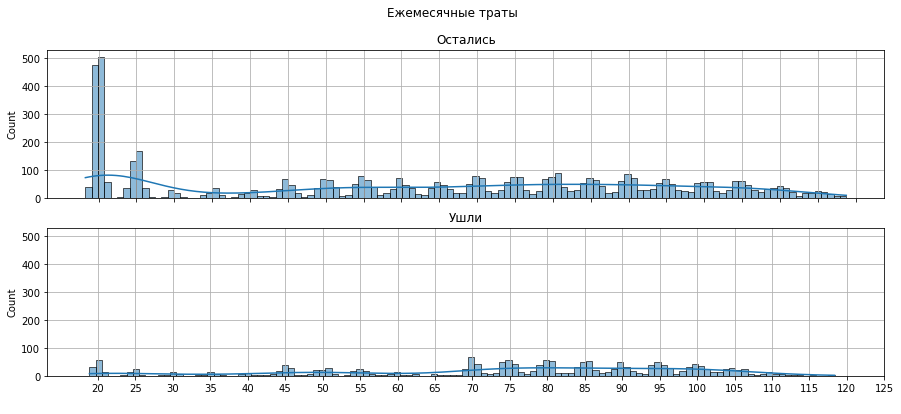

In [54]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15,6))
fig.suptitle('Ежемесячные траты')
plt.xlabel(' ')
axes[0].grid()
axes[1].grid()

#остались
sns.histplot(data=data[data['churn'] == 0], x="monthly_charges", bins=120, kde=True, ax=axes[0])
axes[0].set_title('Остались')

# ушли
sns.histplot(data=data[data['churn'] == 1], x="monthly_charges", bins=120, kde=True, ax=axes[1])
plt.xticks(np.arange(20, 130, 5))
axes[1].set_title('Ушли');

На графике мы видим, что большинство лояльных клиентов тратят на услуги связи 20-30 в месяц, тогда как большинство ушедших клиентов тратили на услуги провайдера сумму больше среднего значения 64 в месяц.

Рассмотрим соотношение между лояльными и нелояльными клиентами среди пользователей интернет-услуг компании и тех, кто пользуется услугами стационарной телефонной связи:

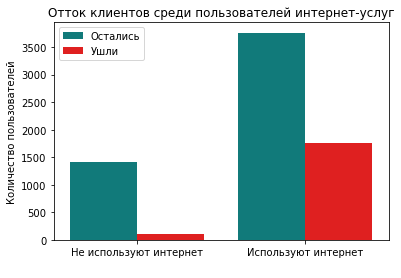

In [55]:
sns.countplot(x="internet_user", hue="churn", data=data, palette=palette)
plt.xticks(
    [0, 1], 
    ["Не используют интернет", "Используют интернет"])
plt.legend(title=False, loc='upper left', labels=['Остались', 'Ушли'])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов среди пользователей интернет-услуг');

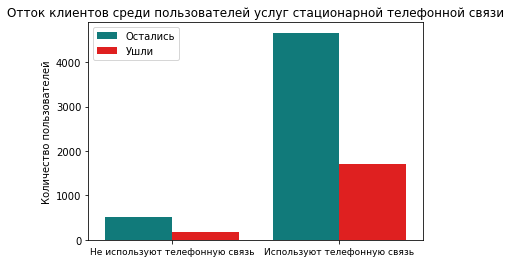

In [56]:
sns.countplot(x="phone_user", hue="churn", data=data, palette=palette)
plt.xticks(
    [0, 1], 
    ["Не используют телефонную связь", "Используют телефонную связь"], fontsize=9)
plt.legend(title=False, loc='upper left', labels=['Остались', 'Ушли'])
plt.xlabel(' ')
plt.ylabel('Количество пользователей')
plt.title('Отток клиентов среди пользователей услуг стационарной телефонной связи');

Мы видим небольшое приемущество у стационарного телефона: среди тех, кто не пользуется услугами стационарной телефонной связи, соотношение нелояльных клиентов к лояльным выше, чем в остальных группах. Так же видим, что среди пользователей интернета чаще встречаются недовольные клиенты по сравнению с пользователями стационарного телефона. Клиенты, которые не являются пользователями интернета от нашей компании (а, следовательно, являются *только* абонентами стационарной телефонной связи), чаще остаются довольны качеством услуг.

### Выводы исследовательского анализа данных <a id="EDA_result"></a>

1. Развитие компании оставалось стабильным на протяжении последних 7 лет. В конце 2019 и в 2020 году количество новых клиентов начало резко расти, но и отток клиентов так же резко вырос в конце 2019. В целом, с компанией работает много лояльных клиентов, продолжающих пользоваться услугами длительное время.
2. Наиболее лояльными клиентами являются:
    * заключающие годичные и двухгодичные контракты;
    * подключающие автоплатёж;
3. Пользователи интернета через оптоволокно чаще уходят, чем пользователи DSL подключения
4. Среди пользователей телефоном больше процент довольных клиентов, чем среди пользователей интернета от компании.

## Обучение моделей <a id="model"></a>

Подготовим данные к обучению моделей
1. Удалим столбец total_charges как кореллирующий
2. Удалим столбец с идентификатором пользователя
3. Применим One Hot Encoding
4. Разделим выборки на обучающую и тестовую
5. Обучим модели и проверим их с помощью кросс-валидации

In [57]:
df = data.drop(['total_charges', 'customer_id', 'begin_date'], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       7043 non-null   int64  
 1   monthly_charges                         7043 non-null   float64
 2   churn                                   7043 non-null   int64  
 3   contract_duration                       7043 non-null   int64  
 4   senior_citizen                          7043 non-null   int64  
 5   partner                                 7043 non-null   int64  
 6   dependents                              7043 non-null   int64  
 7   online_security                         7043 non-null   float64
 8   online_backup                           7043 non-null   float64
 9   device_protection                       7043 non-null   float64
 10  tech_support                            7043 non-null   floa

In [59]:
features = df.drop(['churn'], axis=1)
target = df['churn']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5282, 23)
(5282,)
(1761, 23)
(1761,)


In [60]:
features.head()

,paperless_billing,monthly_charges,contract_duration,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,multiple_lines,phone_user,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_no service
0,1,29.85,31,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0,0,0,1,0,0,0,0
1,0,56.95,1036,0,0,0,1.0,0.0,1.0,0.0,...,0.0,1.0,1,0,0,0,1,1,0,0
2,1,53.85,61,0,0,0,1.0,1.0,0.0,0.0,...,0.0,1.0,0,0,0,0,1,1,0,0
3,0,42.30,1371,0,0,0,1.0,0.0,1.0,1.0,...,0.0,0.0,1,0,0,0,0,1,0,0
4,1,70.70,61,0,0,0,0.0,0.0,0.0,0.0,...,0.0,1.0,0,0,0,1,0,0,1,0


In [61]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

### Логистическая регрессия <a id="regression"></a>

Подберём гиперпараметры для логистической регрессии и обучим модель:

In [62]:
param_grid_logreg = {
    'penalty' : ['l1', "l2"],
    'C': np.arange(0.1, 3, 0.1),
    'solver' : ['liblinear']    
}

logreg = GridSearchCV(LogisticRegression(),
                         param_grid = param_grid_logreg,
                         scoring=roc_auc_scorer, cv = 5, verbose = 1)
logreg.fit(features_train, target_train)

Fitting 5 folds for each of 58 candidates, totalling 290 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=1)

In [63]:
print('Наилучшие параметры:', logreg.best_estimator_)
print('Среднее значение AUC-ROC логистической регрессии после кросс-валидации: {:.2f}'.format(logreg.best_score_))

Наилучшие параметры: LogisticRegression(C=1.4000000000000001, penalty='l1', solver='liblinear')
Среднее значение AUC-ROC логистической регрессии после кросс-валидации: 0.84


### Градиентный бустинг LGBM <a id="lgbm"></a>

Подберём гиперпараметры и обучим модель:

In [64]:
params = {
    'num_leaves': [20, 50, 250, 400],
    'learning_rate':[0.1, 0.2, 0.03, 0.003],
    'max_depth': [3, 5, 8, 10],
    'n_estimators':[10, 20, 50, 100, 200]
}

print('Запуск GridSearch...')
lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=12345), params, scoring=roc_auc_scorer, cv=5, verbose = 1)
lgbm.fit(features_train, target_train)

Запуск GridSearch...
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.2, 0.03, 0.003],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [10, 20, 50, 100, 200],
                         'num_leaves': [20, 50, 250, 400]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=1)

In [65]:
print('Лучшие параметры:')
print(lgbm.best_params_)

print('Среднее значение AUC-ROC после кросс-валидации:')
print(lgbm.best_score_)

Лучшие параметры:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 20}
Среднее значение AUC-ROC после кросс-валидации:
0.9034548195382428


Построим график важности признаков:

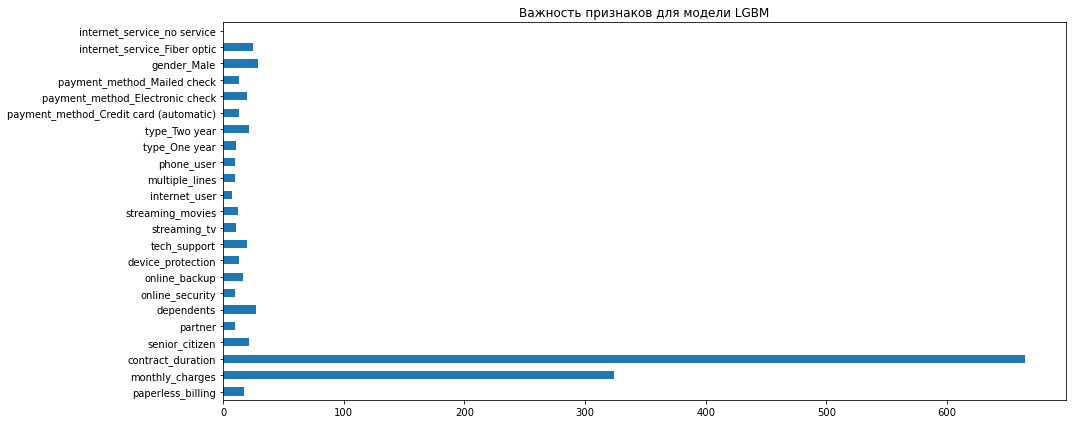

In [66]:
importances = lgbm.best_estimator_.feature_importances_
feature_names = list(features.columns)
lgbm_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,6))
lgbm_importances.plot.barh(ax=ax)
ax.set_title("Важность признаков для модели LGBM")
fig.tight_layout()

Наиболее важные признаки - длительность контракта и ежемесячные траты на услуги.

### Случайный лес <a id="forest"></a>

Подберём параметры и обучим случайный лес:

In [67]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 40, 80, 110],
    'max_features':[2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split':[8, 10, 12],
    'n_estimators': [50, 100, 150, 300]
}

forest = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 5, scoring=roc_auc_scorer, n_jobs = -1, verbose = 2)

forest.fit(features_train, target_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 40, 80, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 150, 300]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=2)

In [68]:
print('Лучшие параметры:')
print(forest.best_params_)

print('Среднее значение AUC-ROC после кросс-валидации:')
print(forest.best_score_)

Лучшие параметры:
{'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Среднее значение AUC-ROC после кросс-валидации:
0.8560524991365028


Построим график важности признаков:

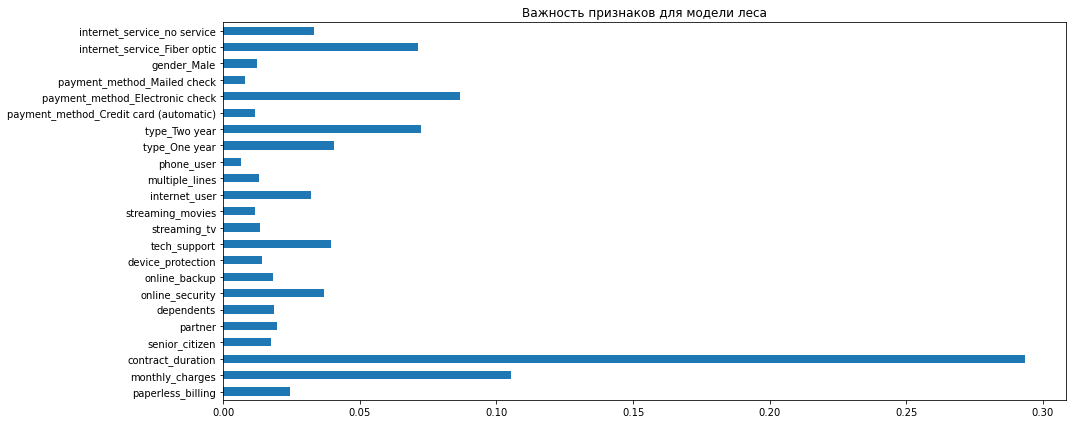

In [69]:
importances = forest.best_estimator_.feature_importances_
feature_names = list(features.columns)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.barh(ax=ax)
ax.set_title("Важность признаков для модели леса")
fig.tight_layout()

Мы получили следующие значения метрики AUC-ROC после валидации:

In [70]:
data = [
    ['Модель логистической регрессии', '{:.2f}'.format(logreg.best_score_)],
    ['Модель градиентного бустинга LightGBM', '{:.2f}'.format(lgbm.best_score_)],
    ['Модель случайного леса', '{:.2f}'.format(forest.best_score_)],
]
columns = ['Модель', 'Значение AUC-ROC']
results = pd.DataFrame(data=data, columns=columns)
results

,Модель,Значение AUC-ROC
0,Модель логистической регрессии,0.84
1,Модель градиентного бустинга LightGBM,0.90
2,Модель случайного леса,0.86


## Проверка моделей <a id="test"></a>

Лучший результат после кросс-валидации показала модель градиентного бустинга - проверим её на тестовой выборке.

In [71]:
lgbm_score = roc_auc_score(target_test, lgbm.predict_proba(features_test)[:, 1])
print('AUC-ROC модели градиентного бустинга LGBM:', '{:.2f}'.format(lgbm_score))

AUC-ROC модели градиентного бустинга LGBM: 0.91


## Выводы <a id="conclusion"></a>

Нам удалось создать модель, с высокой точностью предсказывающую отток клиентов - это модель градиентного бустинга LGBM. Значение целевой метрики AUC-ROC составило 0,91.